In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [115]:
#CSV

df = pd.read_csv('games.csv')

print(df.head())
print(df.info())


                       Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
4     11.27      8.89     10.22         1.00         31.37           NaN   

   Critic_Count  User_Score  User_Count Developer Rating

In [116]:
# DATAFÖRBEREDELSE
# Saknade värden
print(df.isnull().sum())

#Rader & kolumner
print("Shape:", df.shape)

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64
Shape: (16719, 16)


In [117]:
# Ta bort rader utan Name eller Genre
df = df.dropna(subset=['Name', 'Genre'])


#Behåller kolumner
df = df[['Name','Platform','Year_of_Release','Genre','Publisher',
         'NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']]

# Kolla nya formen
print("Shape efter städning:", df.shape)

# Kolla kvarvarande saknade värden (0 betyder inga saknade värden)
print(df.isnull().sum())

Shape efter städning: (16717, 10)
Name                 0
Platform             0
Year_of_Release    269
Genre                0
Publisher           54
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
dtype: int64


In [118]:
# Year of release hade 269 saknade värden och Publisher hade 54. Dessa slängs.


df = df.dropna(subset=['Year_of_Release', 'Publisher'])

# Kolla formen igen
print("Shape efter rensning:", df.shape)

# Dubbelkolla att inga NaN finns kvar
print(df.isnull().sum())

Shape efter rensning: (16416, 10)
Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
dtype: int64


In [119]:
# Exploratory data analys (EDA)

# Grundläggande statistik för försäljningssiffror
print(df.describe())

# Kolla unika värden i kategorikolumner
print("Unika plattformar:", df['Platform'].nunique())
print("Unika genrer:", df['Genre'].nunique())
print("Unika publishers:", df['Publisher'].nunique())


       Year_of_Release      NA_Sales      EU_Sales      JP_Sales  \
count     16416.000000  16416.000000  16416.000000  16416.000000   
mean       2006.489888      0.264129      0.146034      0.078623   
std           5.881148      0.819028      0.507134      0.311348   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2020.000000     41.360000     28.960000     10.220000   

        Other_Sales  Global_Sales  
count  16416.000000  16416.000000  
mean       0.047670      0.536708  
std        0.188156      1.559885  
min        0.000000      0.010000  
25%        0.000000      0.060000  
50%        0.010000      0.170000  
75%        0.030000      0.470000  
max       10.570000     82.530000  
Unika plattformar: 31
Unika genrer: 12
Unika publishers: 580


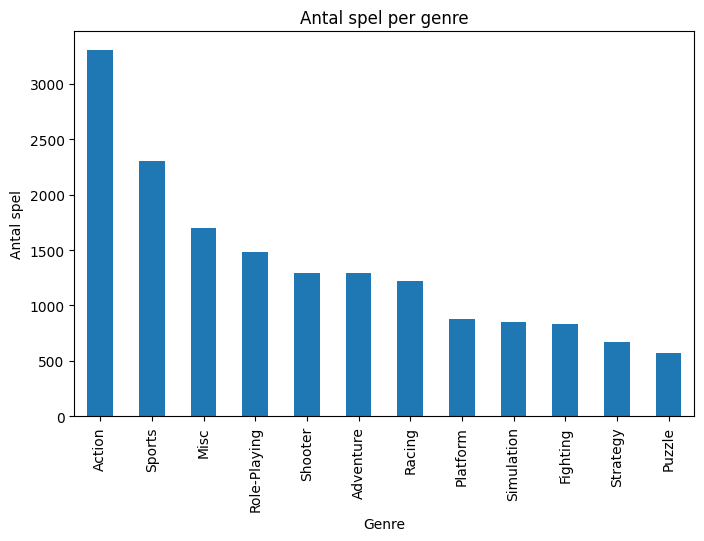

In [120]:
# Antal spel per genre
df['Genre'].value_counts().plot(kind='bar', figsize=(8,5))

plt.title("Antal spel per genre")
plt.xlabel("Genre")
plt.ylabel("Antal spel")
plt.show()

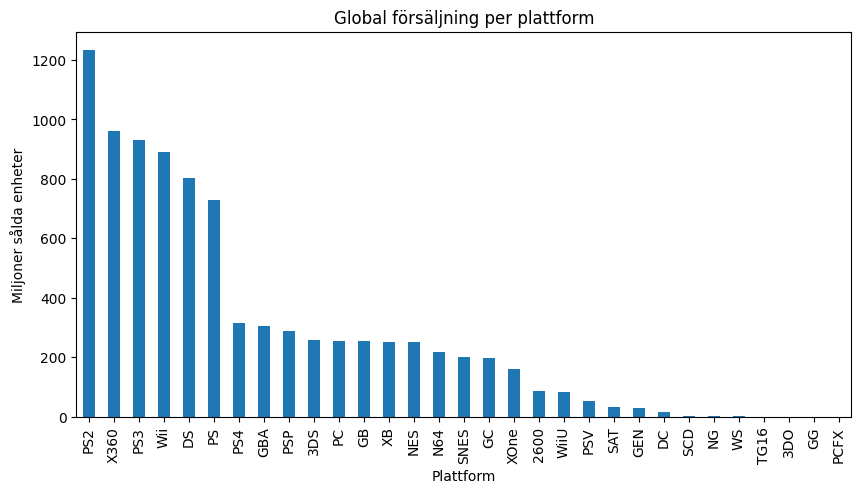

In [121]:
# Global försäljning per plattform (sorterad)
df.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

plt.title("Global försäljning per plattform")
plt.xlabel("Plattform")
plt.ylabel("Miljoner sålda enheter")
plt.show()


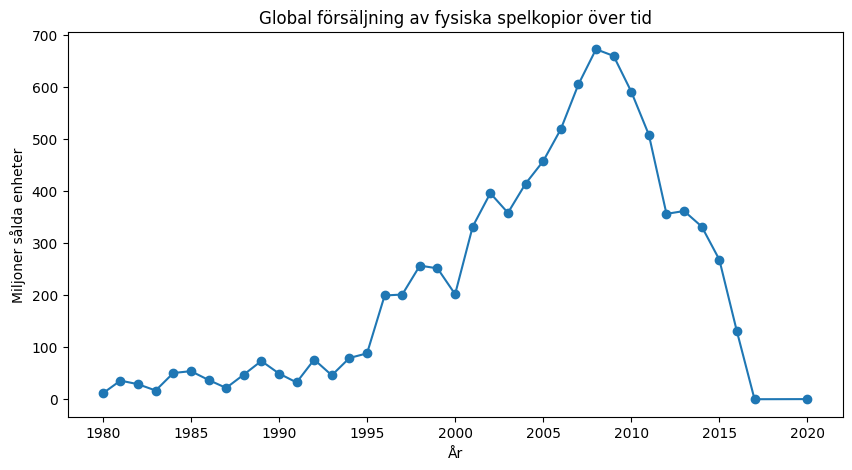

In [122]:
# Hur marknaden har utvecklats över tid
# Summera global försäljning per år
sales_per_year = df.groupby('Year_of_Release')['Global_Sales'].sum()

# Plotta
sales_per_year.plot(kind='line', figsize=(10,5), marker='o')

plt.title("Global försäljning av fysiska spelkopior över tid")
plt.xlabel("År")
plt.ylabel("Miljoner sålda enheter")
plt.show()



In [123]:
# Klassificering

# Skapa en binär variabel för succéspel. 1 = Succe  0 = Inte succé
df['Success'] = (df['Global_Sales'] > 1.0).astype(int)

# Kolla fördelningen
print(df['Success'].value_counts())

Success
0    14383
1     2033
Name: count, dtype: int64


In [124]:
# Features och mål
X = df[['Platform','Year_of_Release','Genre','Publisher']]
y = df['Success']

# One-hot encoding för kategoriska variabler
X = pd.get_dummies(X, drop_first=True)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (13132, 621)
Test shape: (3284, 621)


In [125]:
#Random forest modell

# Skapa modellen
model = RandomForestClassifier(random_state=42)

# Träna modellen
model.fit(X_train, y_train)

# Gör predictioner
y_pred = model.predict(X_test)

# Utvärdera
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2700  201]
 [ 249  134]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2901
           1       0.40      0.35      0.37       383

    accuracy                           0.86      3284
   macro avg       0.66      0.64      0.65      3284
weighted avg       0.86      0.86      0.86      3284



In [127]:
# XGBoost modell

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Gör predictioner
y_pred_xgb = xgb_model.predict(X_test)

# Utvärdera
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

c:\Users\Burak\anaconda3\envs\miljo\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:57:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[2827   74]
 [ 279  104]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2901
           1       0.58      0.27      0.37       383

    accuracy                           0.89      3284
   macro avg       0.75      0.62      0.66      3284
weighted avg       0.87      0.89      0.87      3284



In [ ]:
# SLUTSATS
#
# I det här projektet har jag analyserat ett dataset med global försäljning 
# av fysiska spelkopior. 
#
# Genom min EDA såg jag att:
# - Action och Sports är de mest populära genrerna.
# - Plattformar som PS2, X360 och PS3 har haft störst försäljningssiffror.
# - Den globala försäljningen av fysiska spelkopior nådde sin topp runt 2008–2010, 
#   men har minskat sedan dess.
#
# Jag tränade två modeller: Random Forest och XGBoost, för att förutsäga om ett spel 
# blev en succé eller inte. Båda modellerna fick en hög total accuracy (ca 86–89%), 
# men båda hade svårt att förutsäga succéspel korrekt. 
#
# Resultatet visar att problemet inte ligger i vilken modell som används, 
# utan att datasetet är obalanserat (det finns betydligt fler spel som inte blev succéer). 
# Därför är modellerna mycket bra på att förutsäga floppar, men svagare på succéer.
#
# Min hypotes är att nedgången i försäljning inte betyder att spel har blivit mindre populära, 
# utan att marknaden har skiftat till digital distribution, mobilspel och abonnemangstjänster. 
#
# Om jag skulle utveckla projektet vidare hade jag:
# - Försökt hitta en mer balanserad dataset som inkluderar digital försäljning.
# - Testat tekniker för att balansera datan (till exempel SMOTE eller class weights).
# - Jämfört fler modeller för att se om någon kunde prestera bättre på att förutsäga succéspel.
